In [3]:
from deap import base, creator, tools, algorithms
from functools import  partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="deap.creator")

# Import des données

In [76]:
df = pd.read_csv('../data/application_train_vf.csv')

In [16]:
df["date_mensuelle"] = pd.to_datetime(df["date_mensuelle"])

In [17]:
df['date_trimestrielle'] = df['date_mensuelle'].dt.year.astype(str) + '_' + df['date_mensuelle'].dt.quarter.astype(str)

In [5]:
num = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [6]:
var_to_categorize = [var for var in num if df[var].nunique() < 20]

In [7]:
num_final = [var for var in num if var not in var_to_categorize]

# Variables Numériques

In [8]:
dict_variables = {}

for var in num_final:
    dict_variables[var] = 2

# Discrétisation

In [9]:
def calculate_stability(column):
    stability_df = df.groupby(['date_mensuelle', column])['TARGET'].mean().unstack()
    
    stability_df['stability'] = stability_df.std(axis=1) / stability_df.mean(axis=1)
    return stability_df

In [10]:
def plot_stability(variable):
    stability_df = calculate_stability(variable)  
    plt.figure(figsize=(10, 5))
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [11]:
def evalChi2(individual, variable):
    individual_sorted = sorted(individual)
    percentiles = [max(0, min(i * 100, 100)) for i in individual_sorted]
    thresholds = np.percentile(df[variable].dropna(), percentiles)
    
    thresholds = np.unique(thresholds)
    
    disc_var = np.digitize(df[variable], thresholds)
    df['disc_var'] = disc_var
    
    contingency_table = pd.crosstab(df['disc_var'], df['TARGET'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2,

In [79]:
def Run_Genetic_Discretisation(VARIABLE, NB_CLASSES_MAX):
    NB_GEN = 50
    POP_SIZE = 100  
    CXPB, MUTPB = 0.5, 0.2  


    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    
    def custom_crossover(ind1, ind2):
        if len(ind1) > 1 and len(ind2) > 1:
            return tools.cxTwoPoint(ind1, ind2)
        else:
            return ind1, ind2

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=NB_CLASSES_MAX)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", partial(evalChi2, variable=VARIABLE))
    toolbox.register("mate", custom_crossover)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    population = toolbox.population(n=POP_SIZE)
    algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NB_GEN, verbose=True)
    
    best_ind = tools.selBest(population, 1)[0]
    return(best_ind)

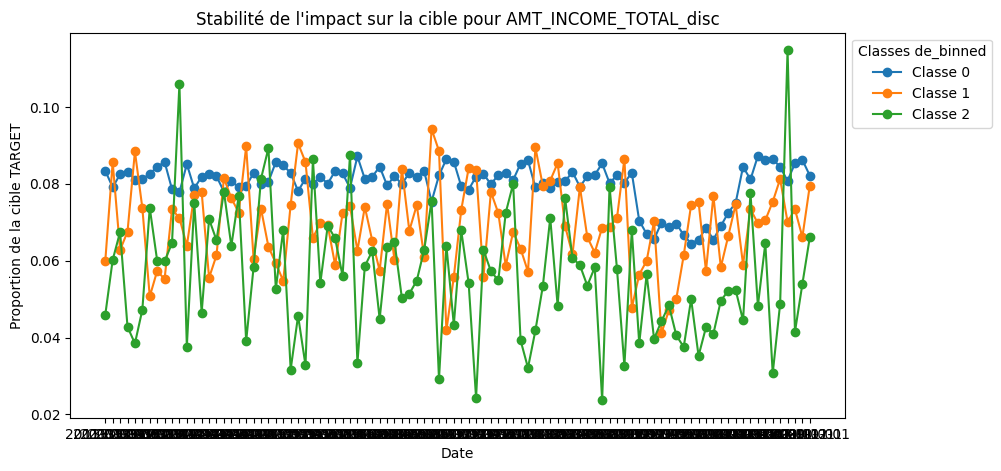

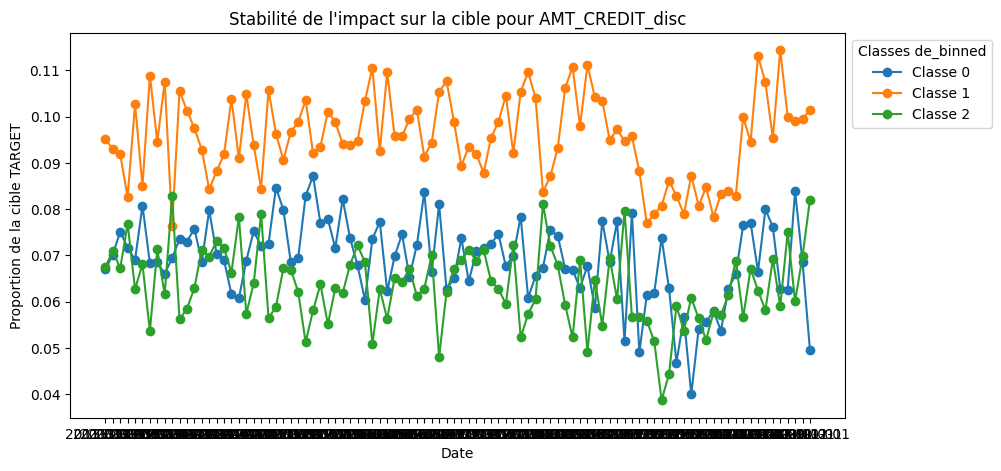

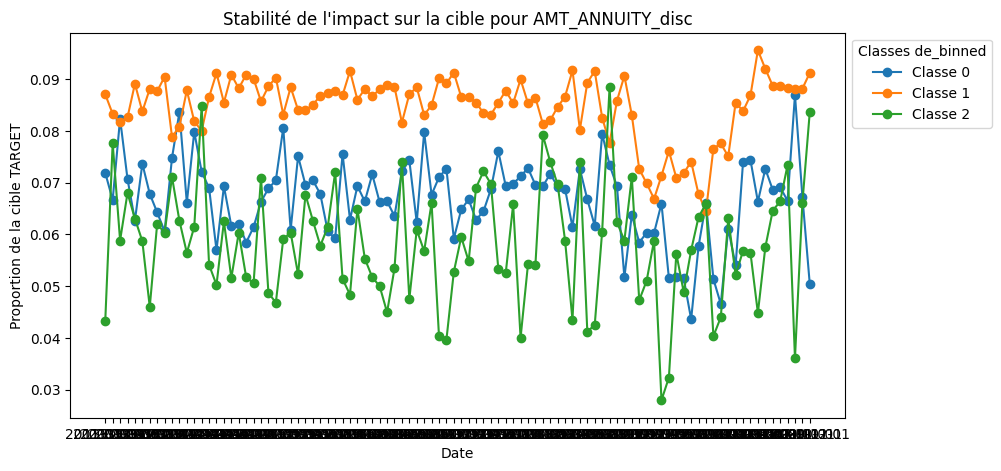

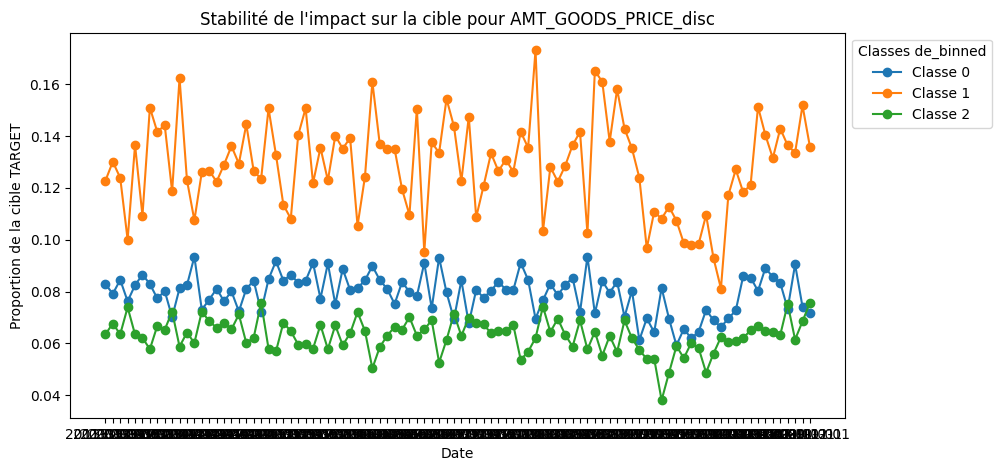

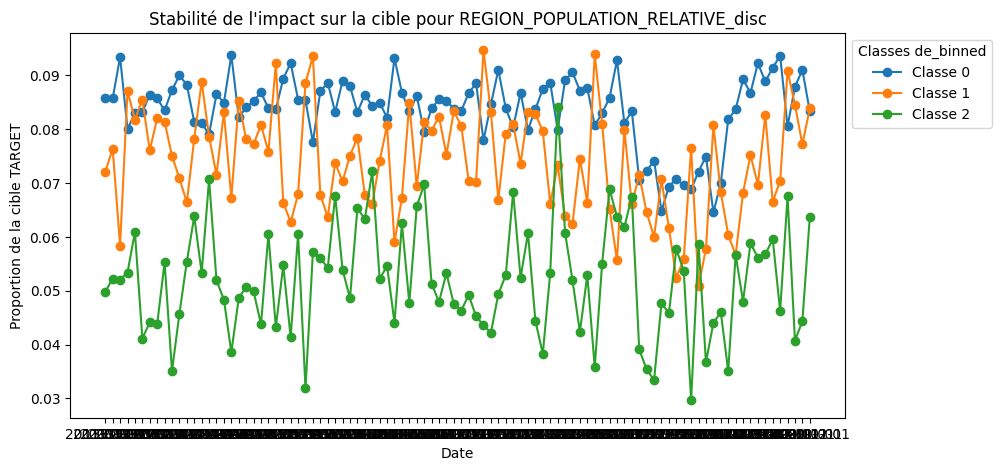

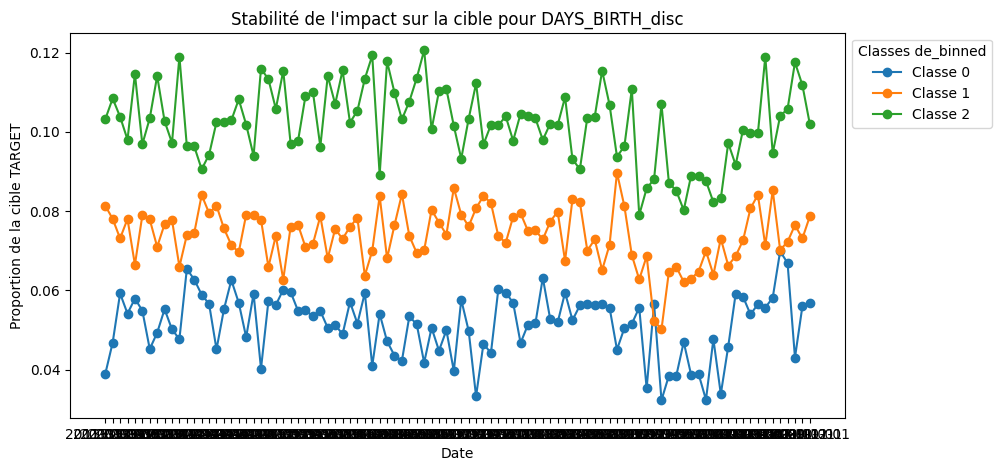

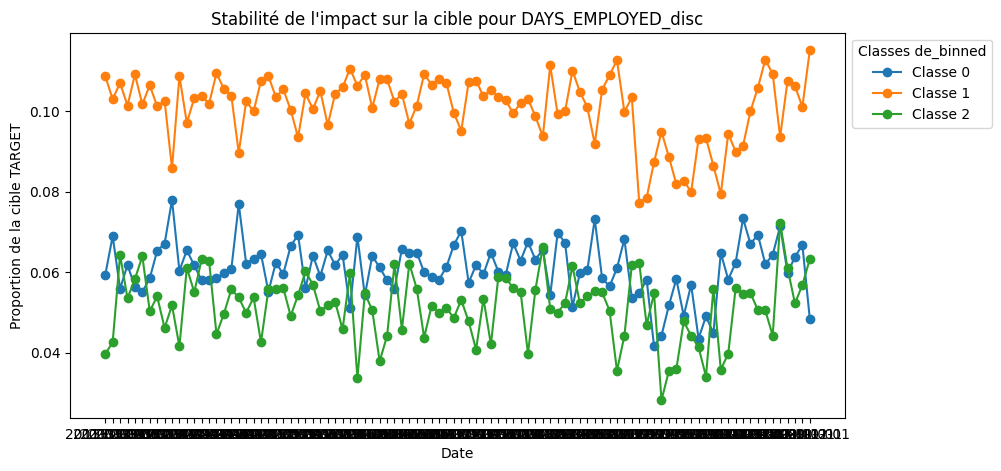

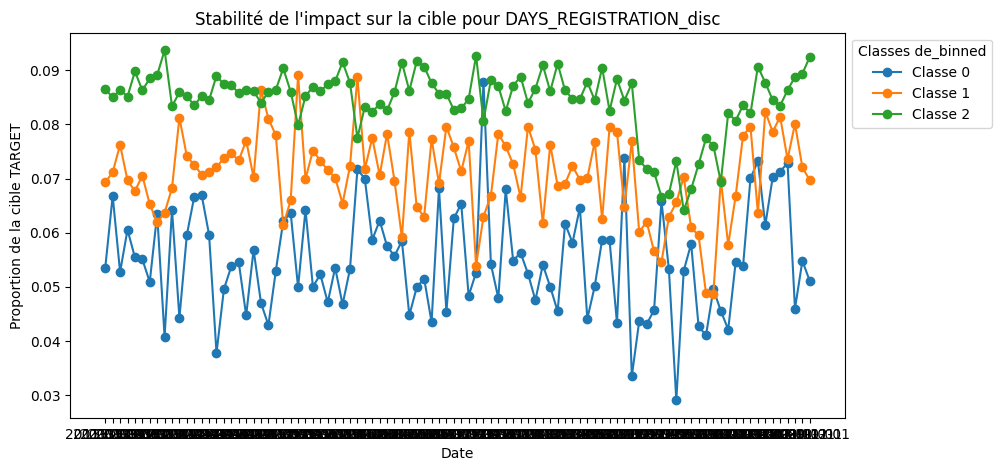

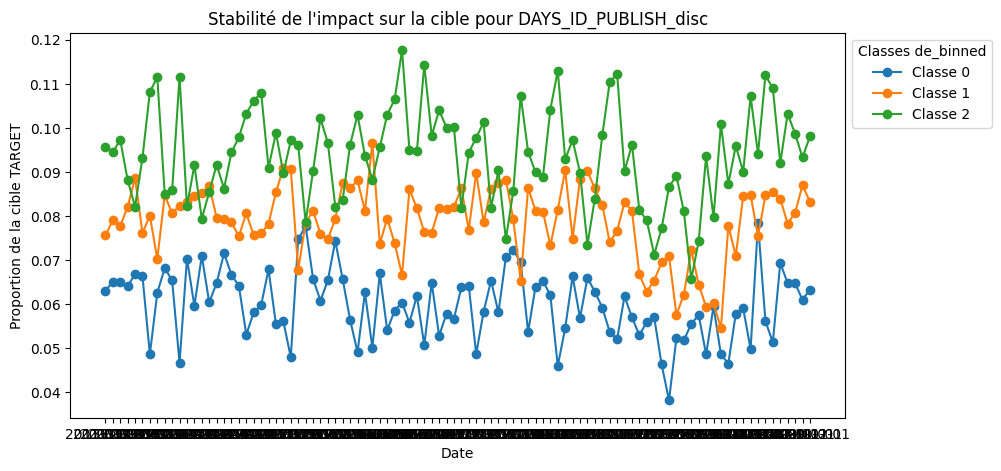

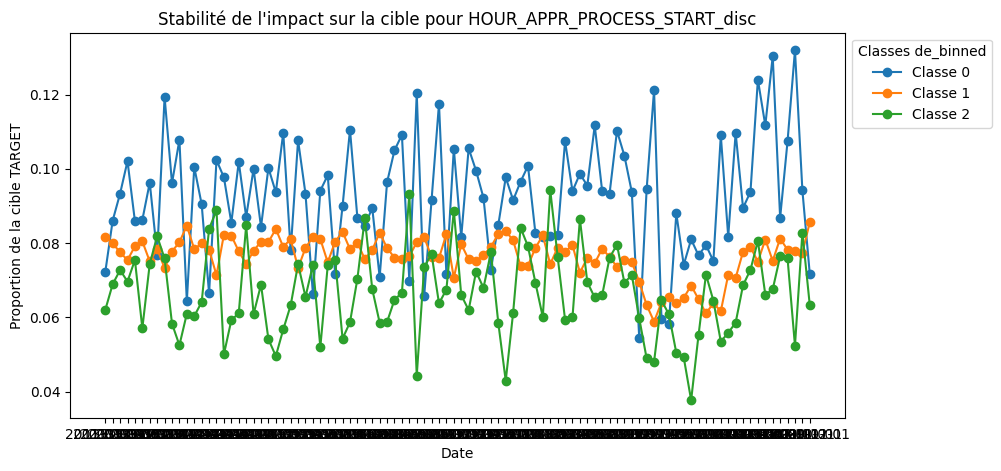

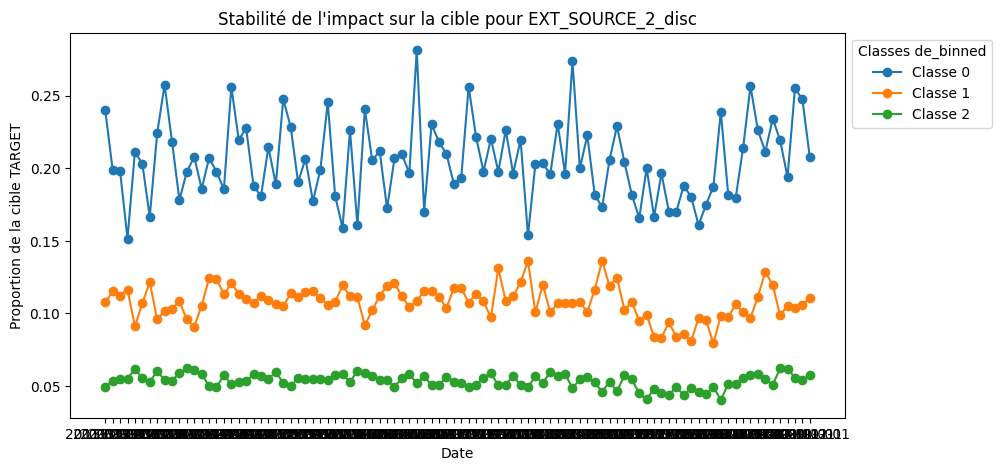

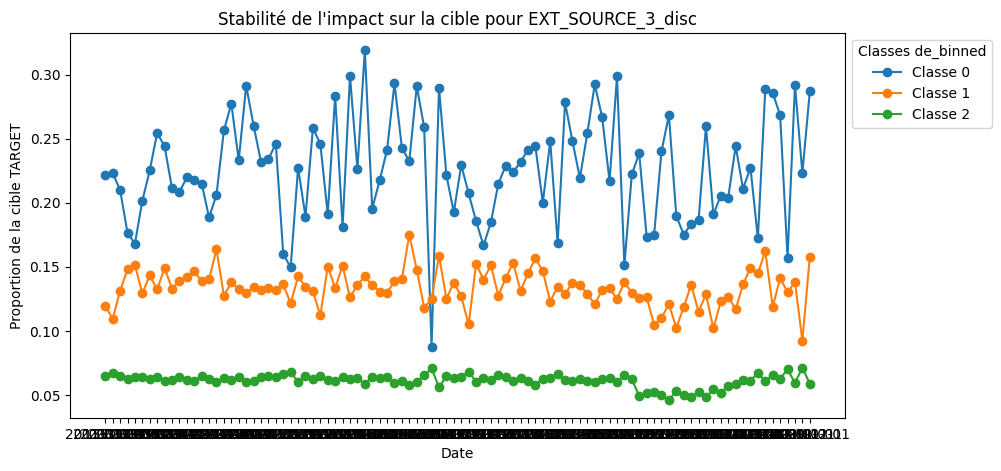

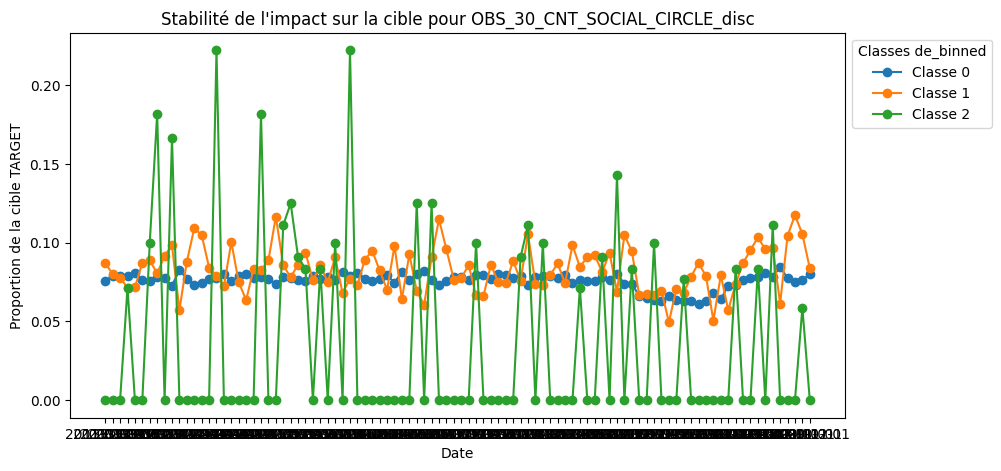

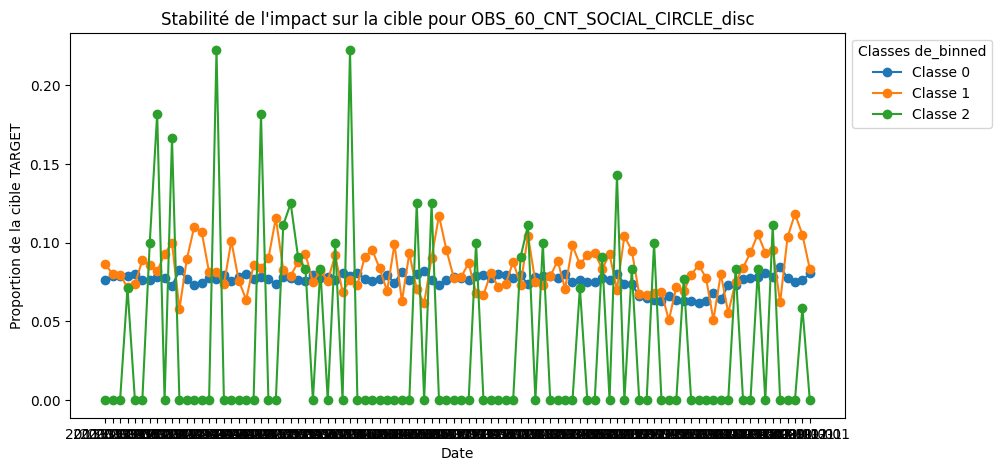

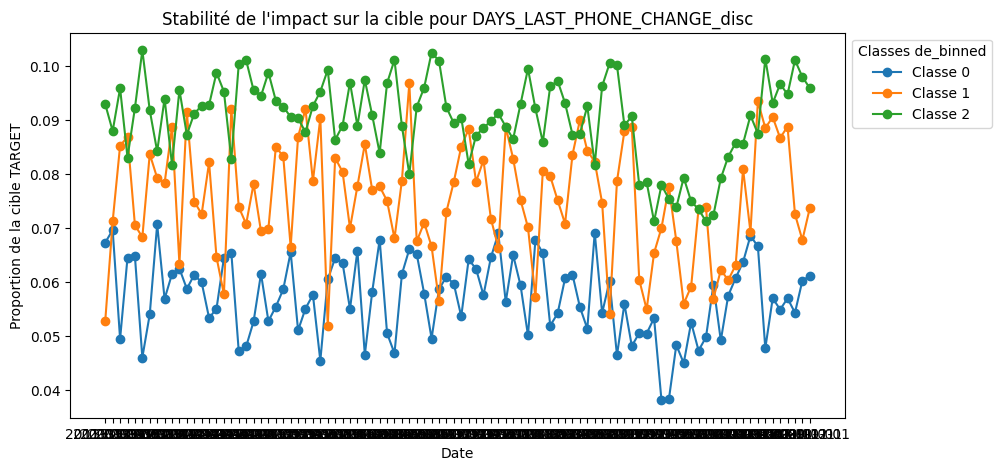

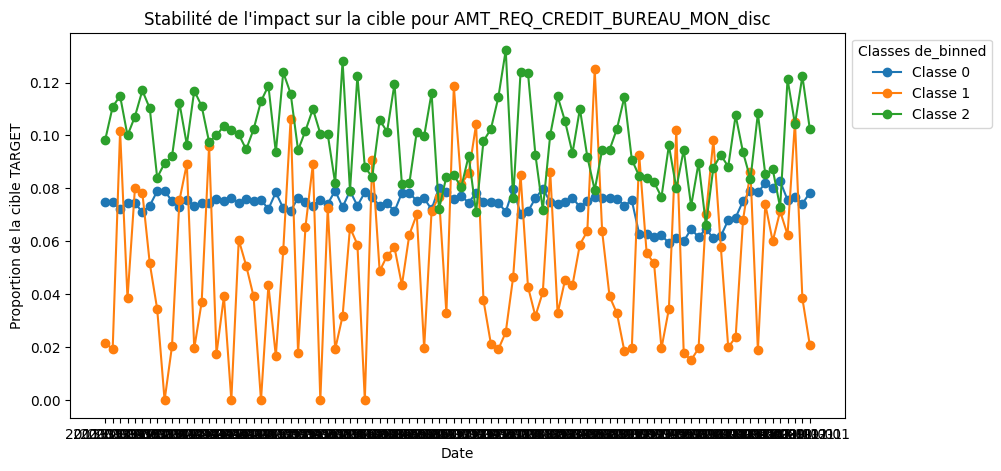

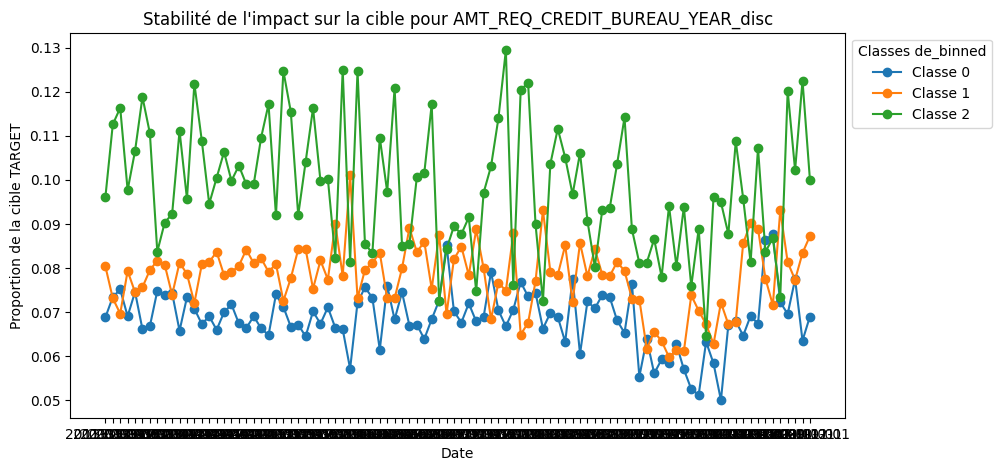

In [128]:
for variable in dict_variables : 
    bins = Run_Genetic_Discretisation(variable, dict_variables[variable])
    bins_normalise = sorted([min(1, max(0, val)) for val in bins])
    
    seuils = np.percentile(df[variable].dropna(), [val * 100 for val in bins_normalise])
    seuils_uniques = np.unique(seuils)
    
    df[f'{variable}_disc'] = np.digitize(df[variable], seuils_uniques)
    
    stability_df = calculate_stability(f'{variable}_disc')  
    plt.figure(figsize=(10, 5))
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}_disc')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [27]:
var_3_good = ["DAYS_BIRTH", "EXT_SOURCE_2", ]

var_2_cat = ["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "REGION_POPULATION_RELATIVE",
             "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "DAYS_LAST_PHONE_CHANGE",
             "AMT_REQ_CREDIT_BUREAU_YEAR", "EXT_SOURCE_3", "AMT_REQ_CREDIT_BUREAU_MON"]

var_bad = ["AMT_INCOME_TOTAL", "HOURS_APPR_PROCESS_START"]

var_a_explorer = ["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE"]

In [28]:
dict_variables_2 = {}

for var in var_2_cat :
    dict_variables_2[var] = 1

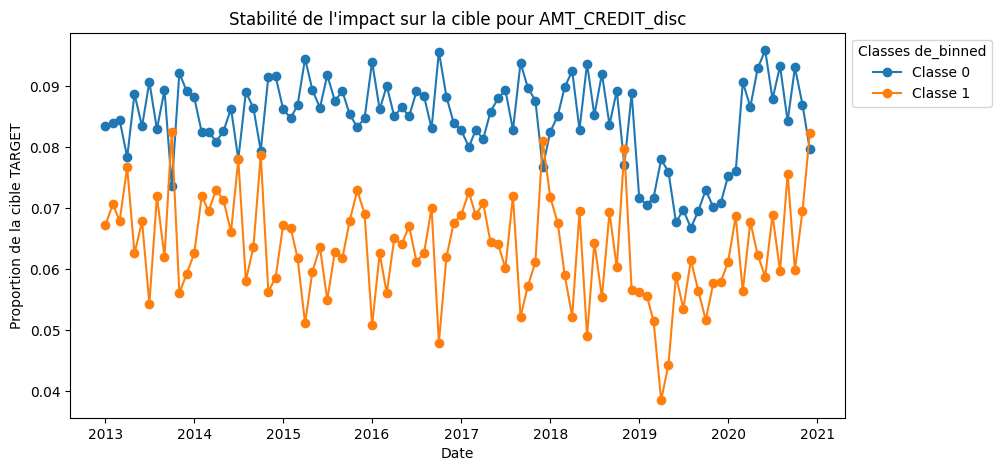

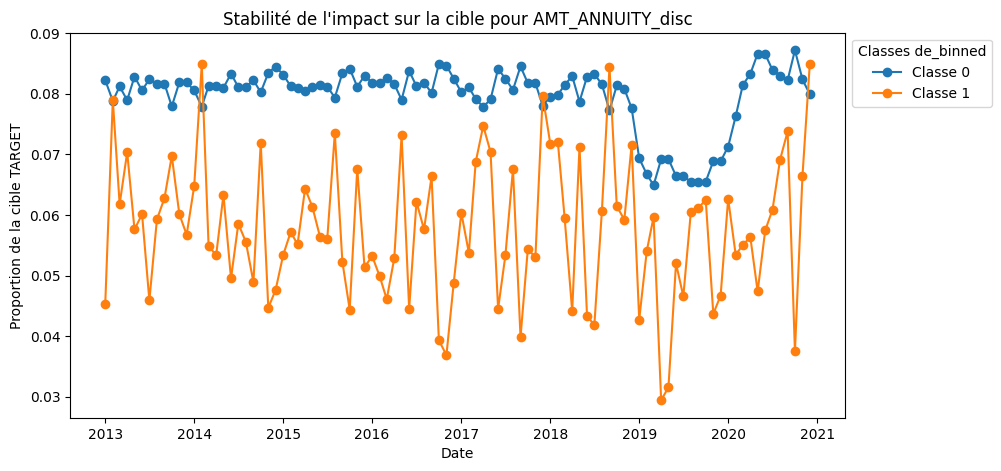

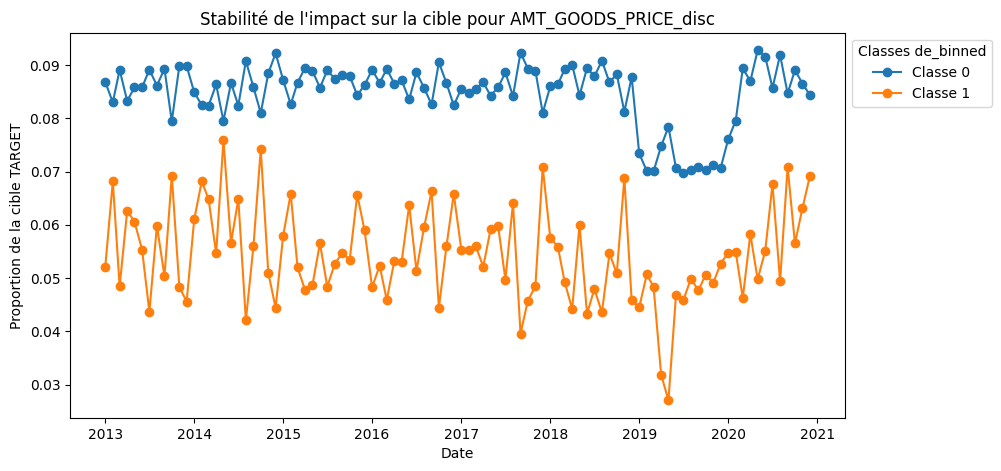

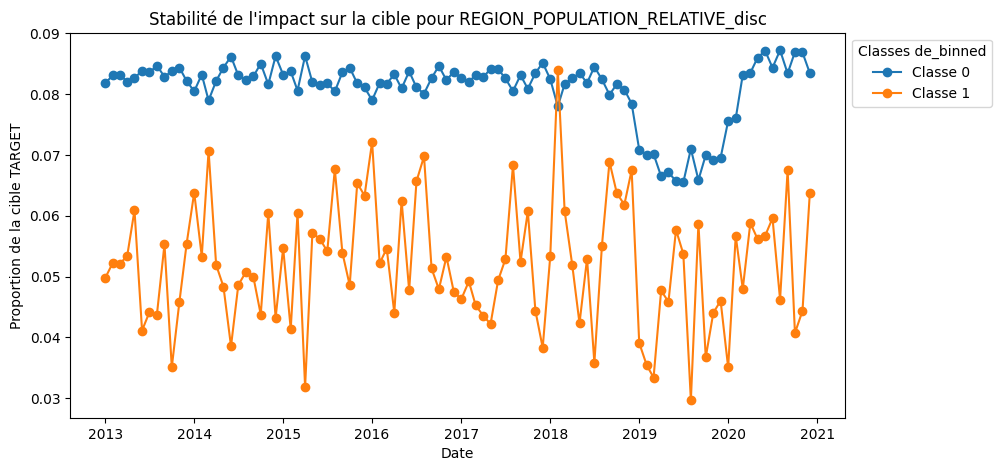

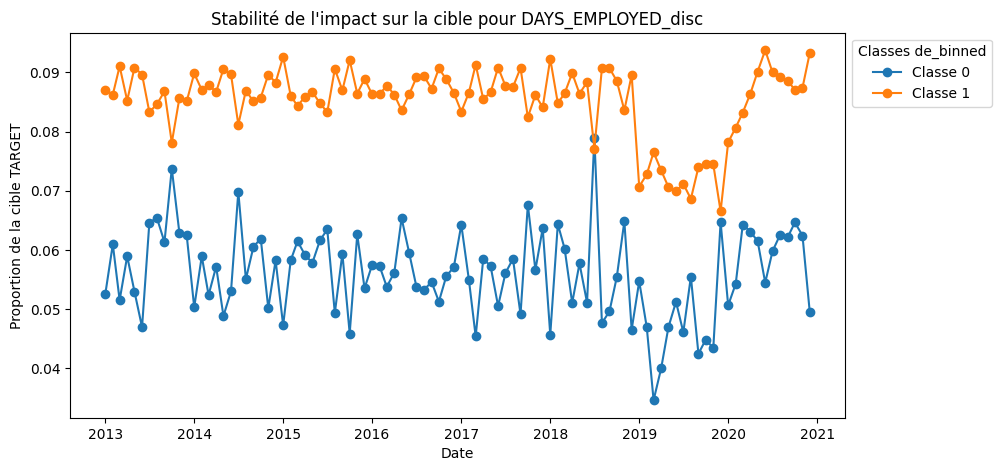

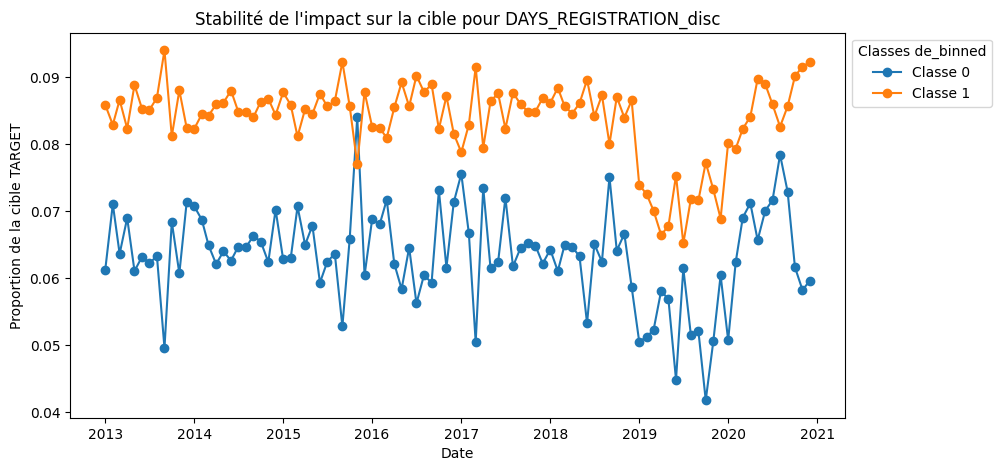

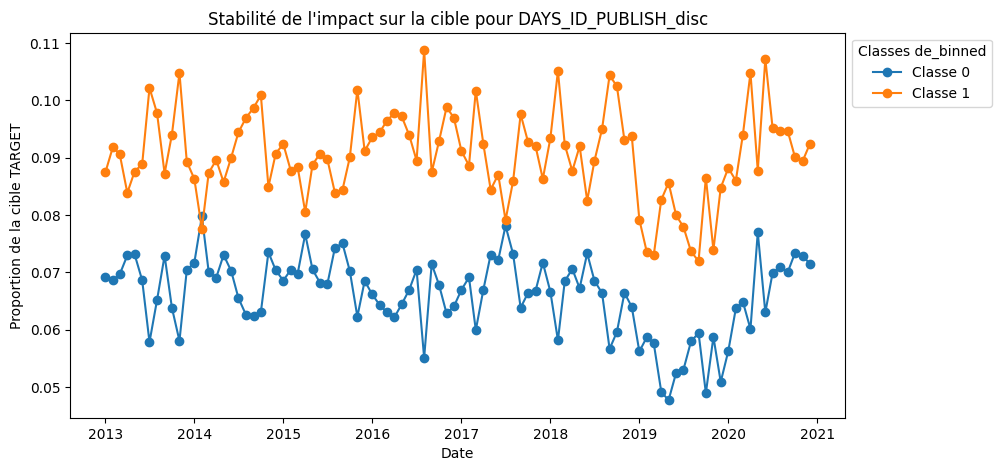

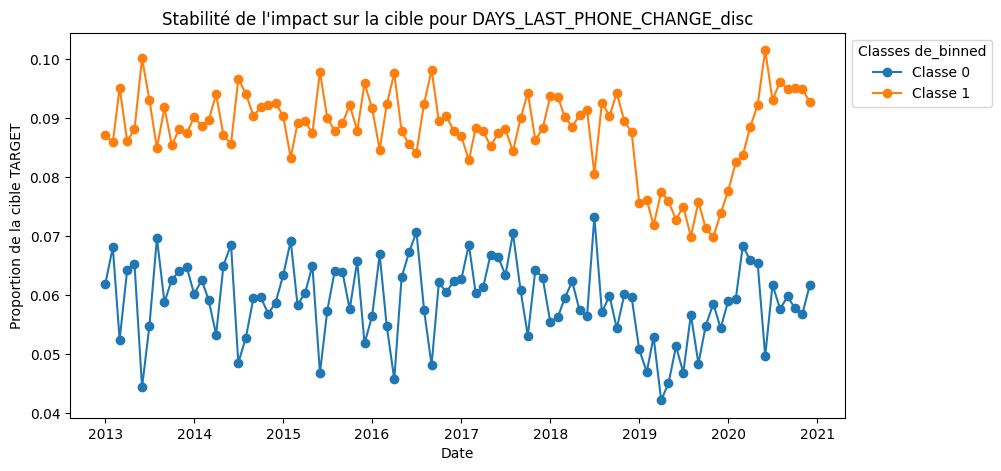

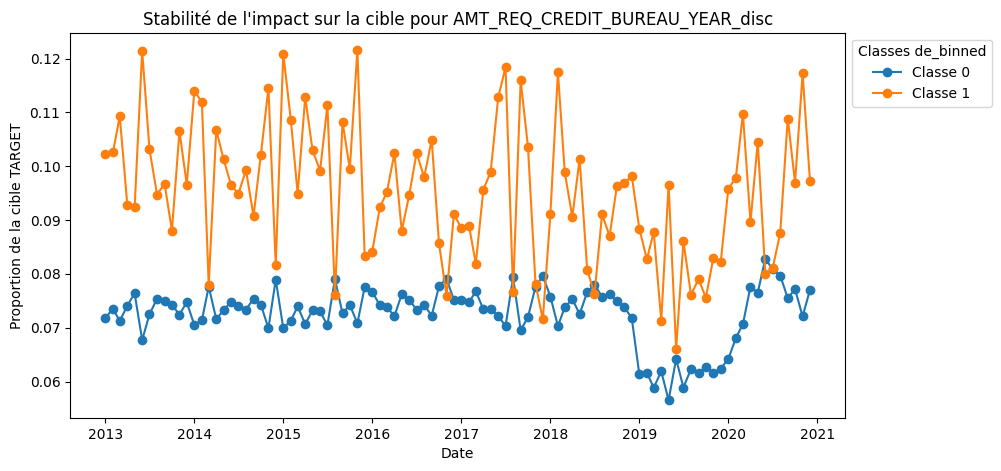

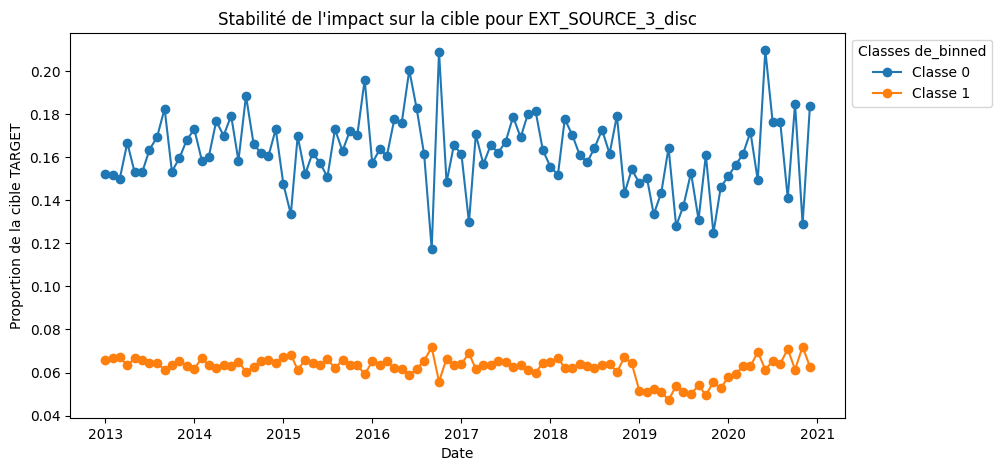

In [29]:
for variable in dict_variables_2 : 
    bins = Run_Genetic_Discretisation(variable, dict_variables_2[variable])
    bins_normalise = sorted([min(1, max(0, val)) for val in bins])
    
    seuils = np.percentile(df[variable].dropna(), [val * 100 for val in bins_normalise])
    seuils_uniques = np.unique(seuils)
    
    df[f'{variable}_disc'] = np.digitize(df[variable], seuils_uniques)
    
    stability_df = calculate_stability(f'{variable}_disc')  
    plt.figure(figsize=(10, 5))
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}_disc')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [80]:
for variable in dict_variables_2 : 
    bins = Run_Genetic_Discretisation(variable, dict_variables_2[variable])
    bins_normalise = sorted([min(1, max(0, val)) for val in bins])
    
    seuils = np.percentile(df[variable].dropna(), [val * 100 for val in bins_normalise])
    seuils_uniques = np.unique(seuils)
    
    df[f'{variable}_disc'] = np.digitize(df[variable], seuils_uniques)
    
    stability_df = calculate_stability(f'{variable}_disc')  
    plt.figure(figsize=(10, 5))
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}_disc')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

gen	nevals
0  	100   
1  	54    
2  	61    
3  	67    
4  	67    
5  	68    


KeyboardInterrupt: 

In [41]:
var_2_cat_good = ["AMT_GOODS_PRICE", "DAYS_REGISTRATION",  "DAYS_LAST_PHONE_CHANGE", "EXT_SOURCE_3"]

var_2_cat_verif = ["AMT_CREDIT", "AMT_ANNUITY",  "REGION_POPULATION_RELATIVE", "DAYS_EMPLOYED",
                   "DAYS_REGISTRATION","DAYS_ID_PUBLISH", "AMT_REQ_CREDIT_BUREAU_YEAR", "AMT_REQ_CREDIT_BUREAU_MON"]

# Vérification trimestrielle

In [42]:
var_to_verif = [str(var + '_disc') for var in var_2_cat_verif ]

In [33]:
df['date_trimestrielle'] = df['date_mensuelle'].dt.year.astype(str) + '_' + df['date_mensuelle'].dt.quarter.astype(str)


def calculate_stability_tri(column):
    stability_df = df.groupby(['date_trimestrielle', column])['TARGET'].mean().unstack()

    stability_df['stability'] = stability_df.std(axis=1) / stability_df.mean(axis=1)
    return stability_df


def plot_stability_tri(variable):
    stability_df = calculate_stability_tri(variable)
    plt.figure(figsize=(10, 5))

    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')

    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

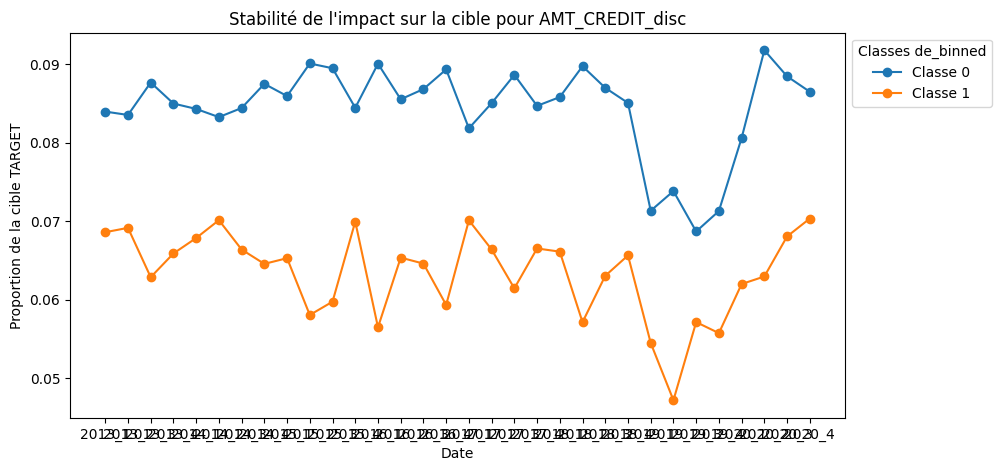

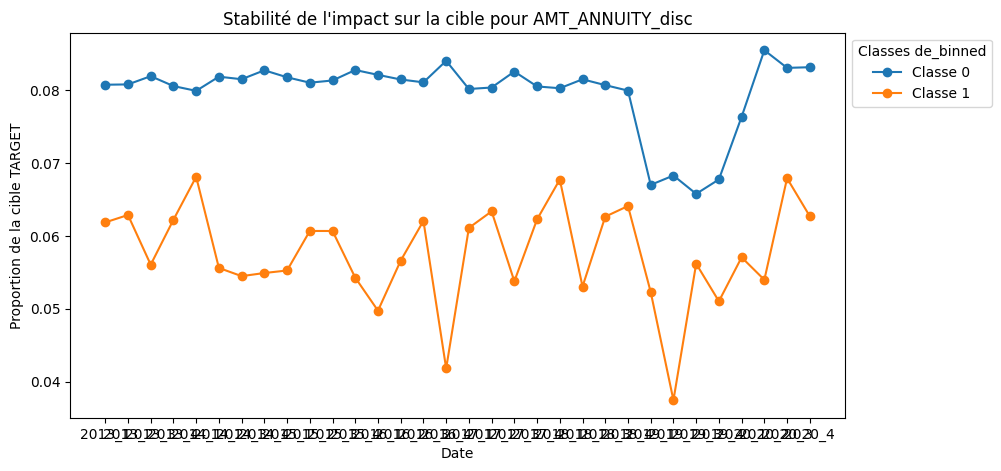

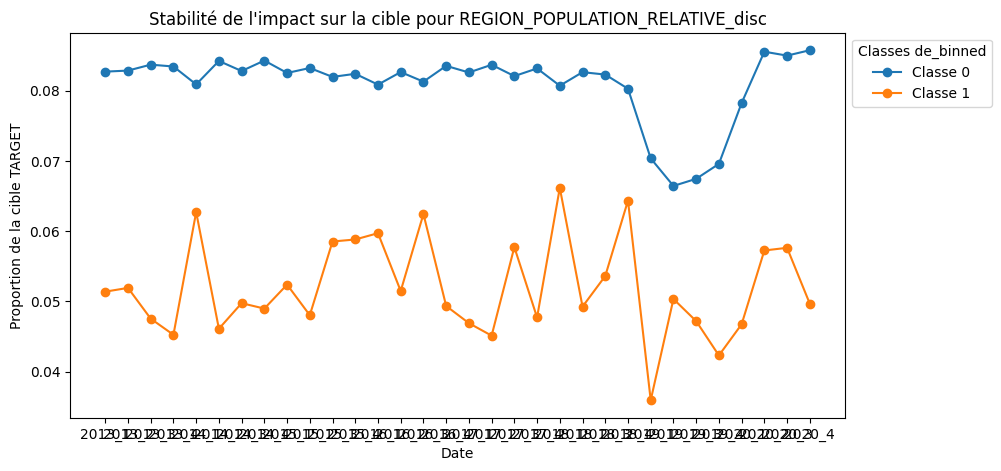

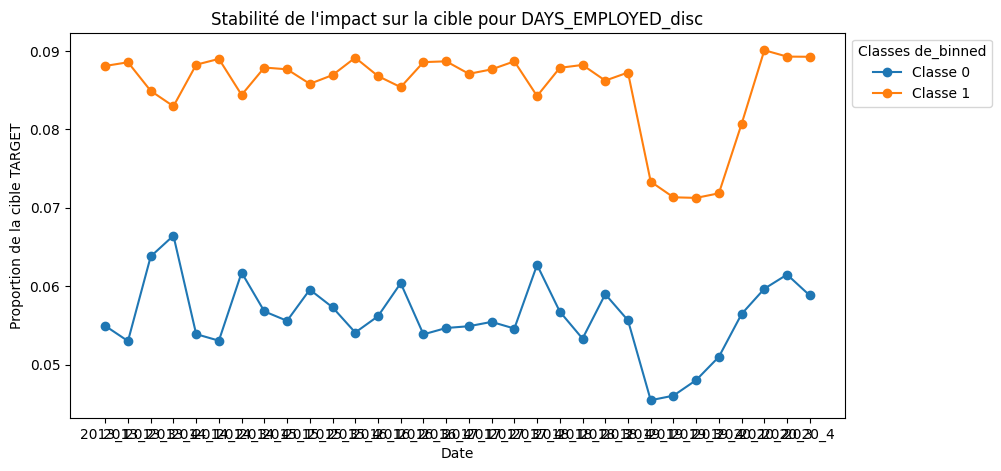

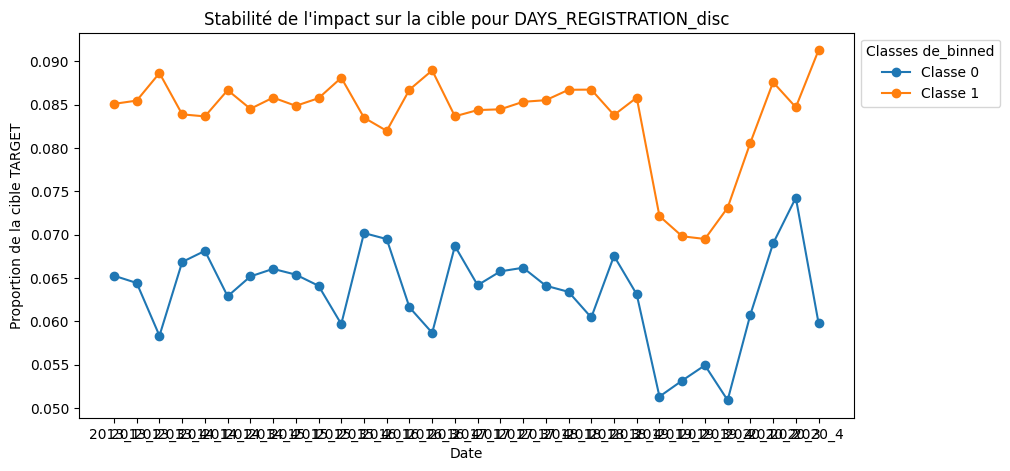

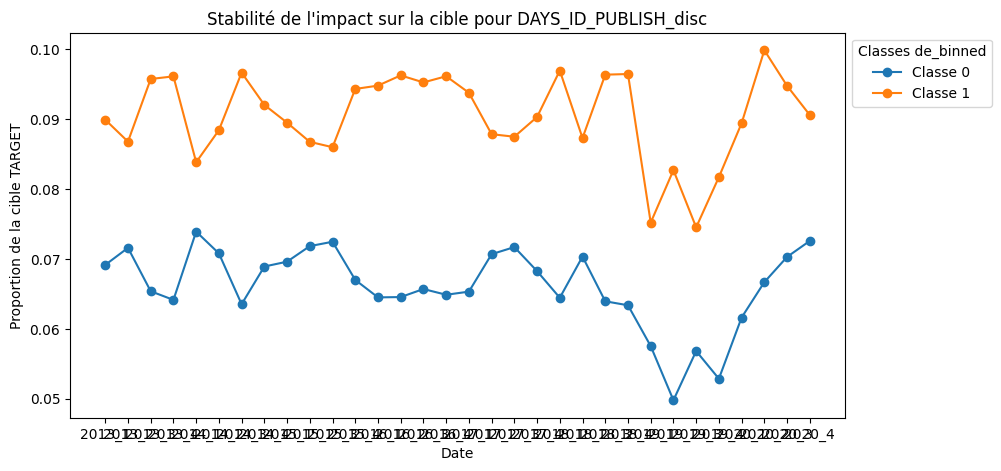

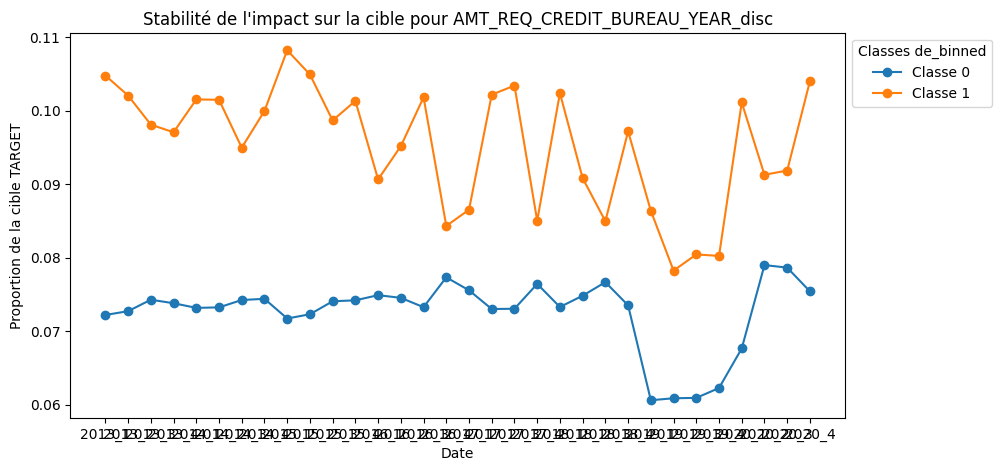

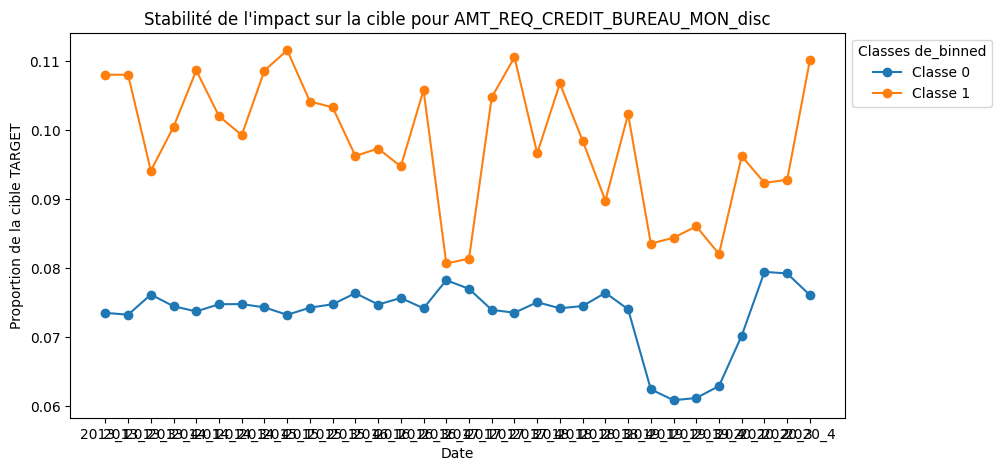

In [43]:
for var in var_to_verif :
    plot_stability_tri(var)

# Discretisation des catégorielles

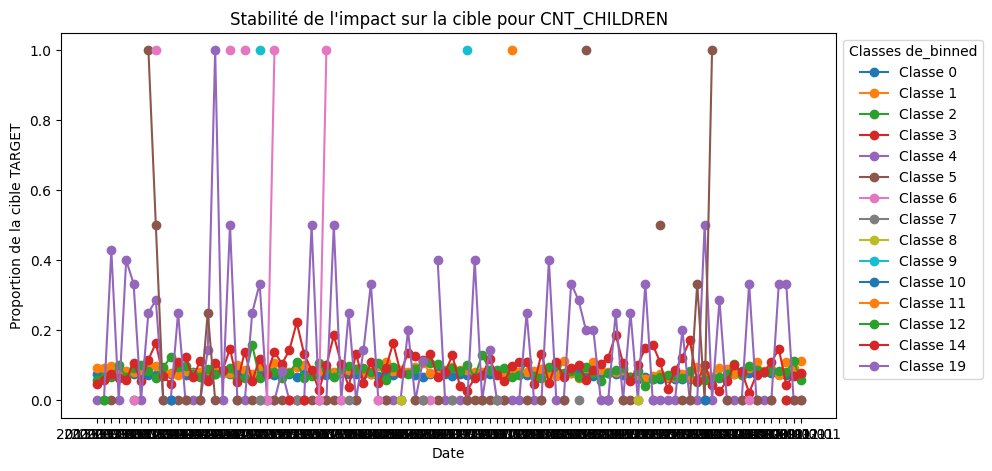

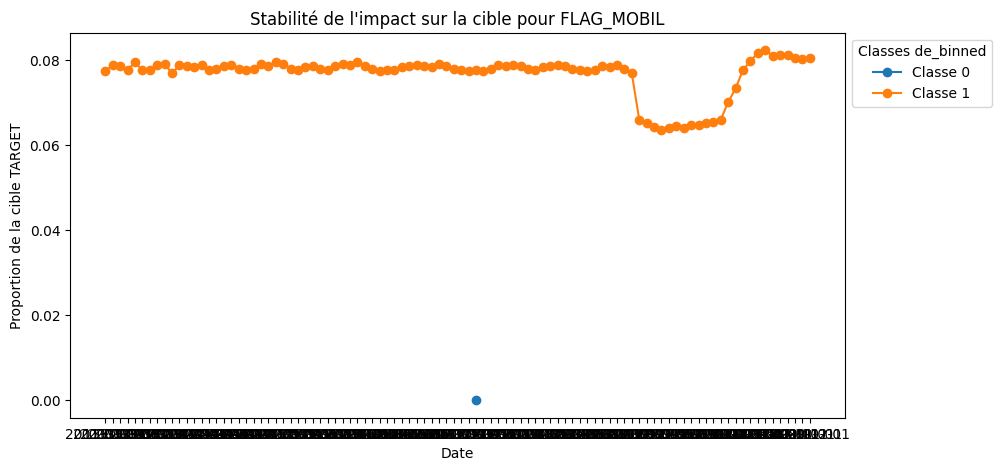

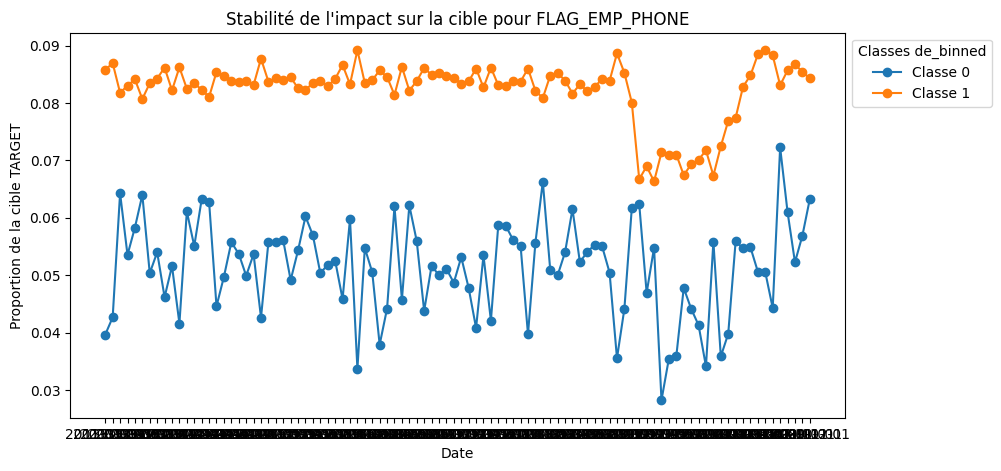

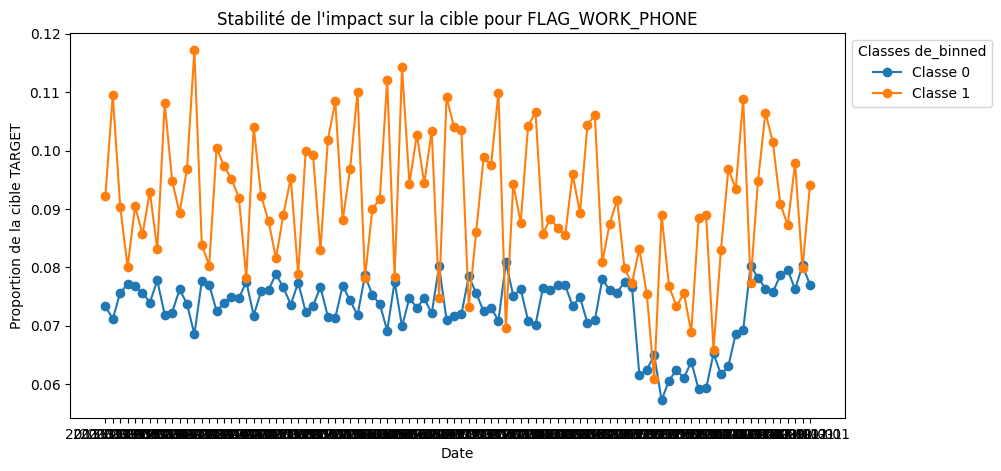

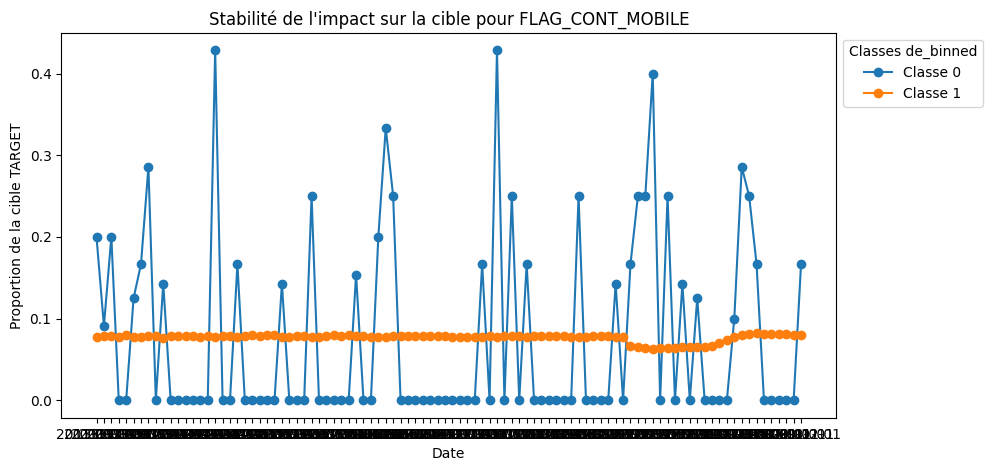

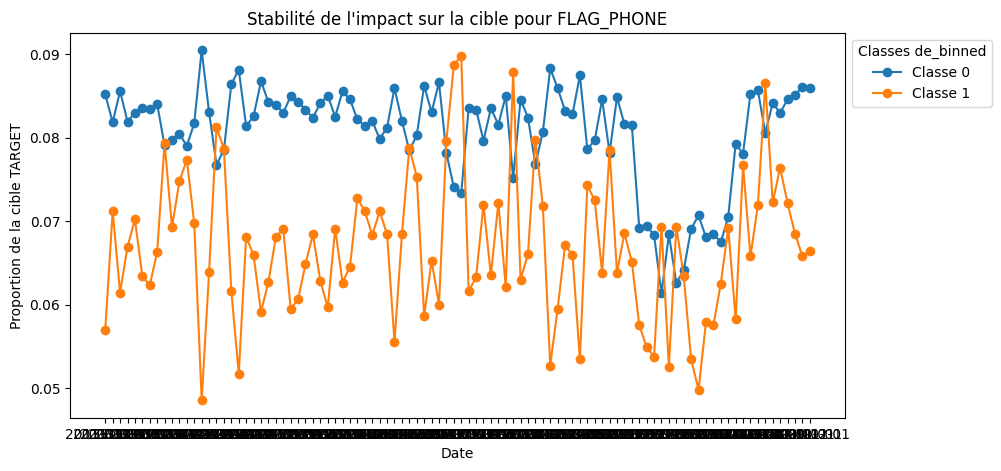

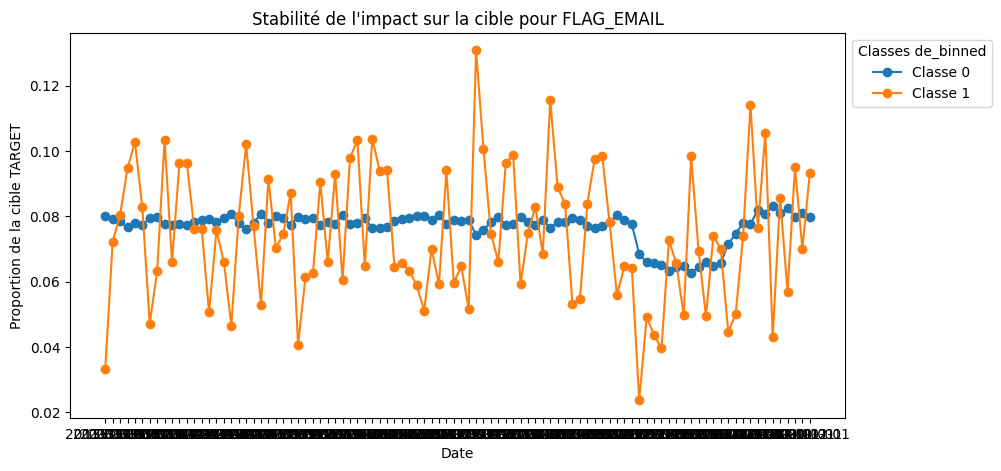

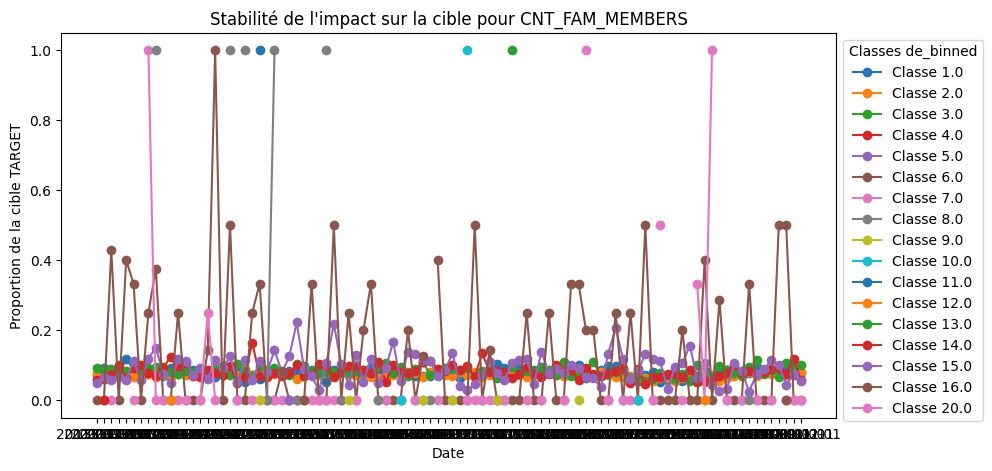

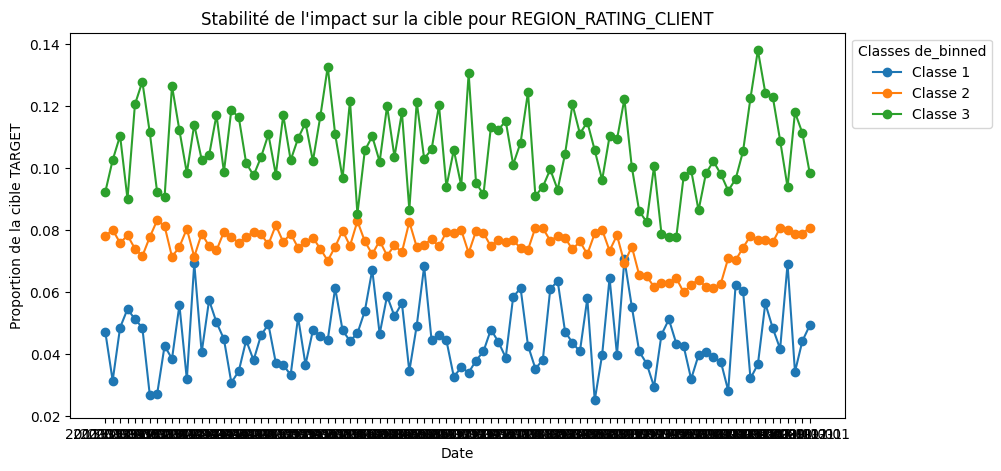

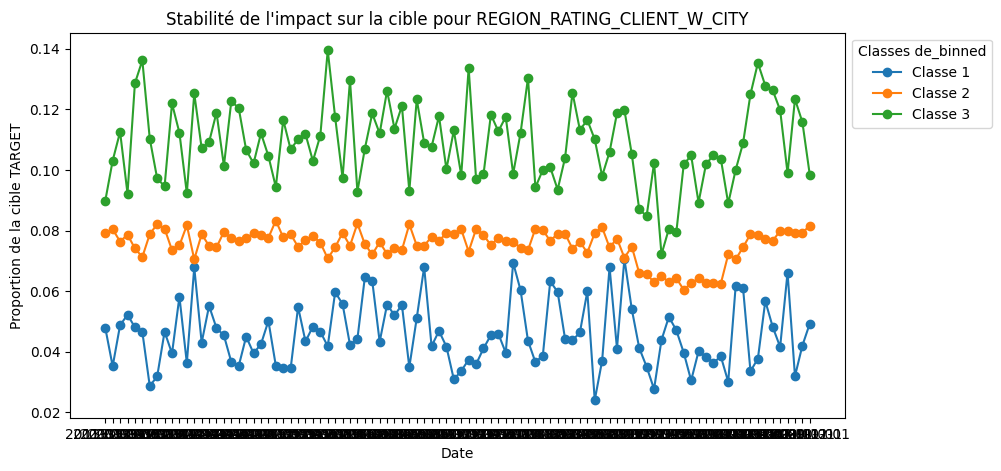

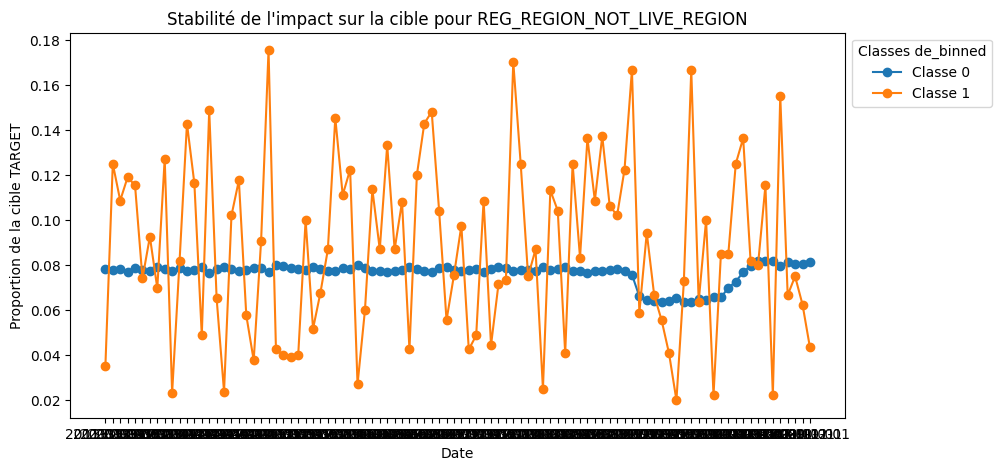

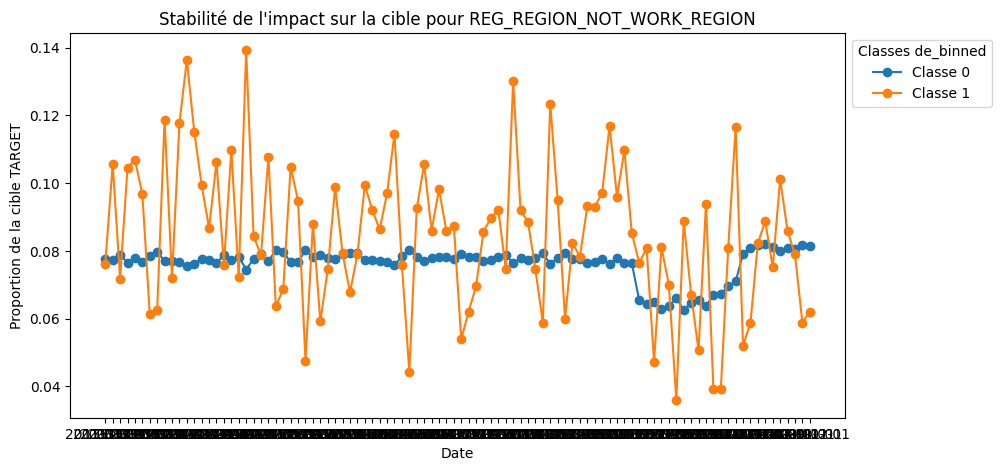

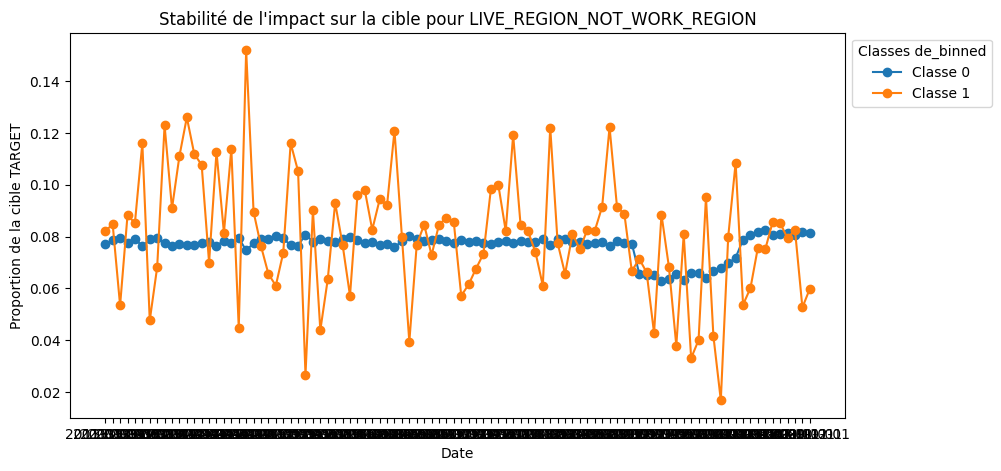

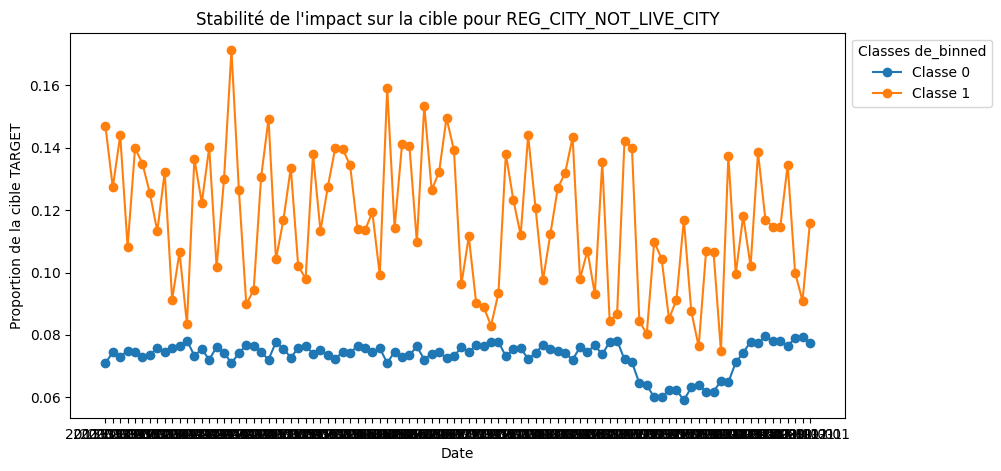

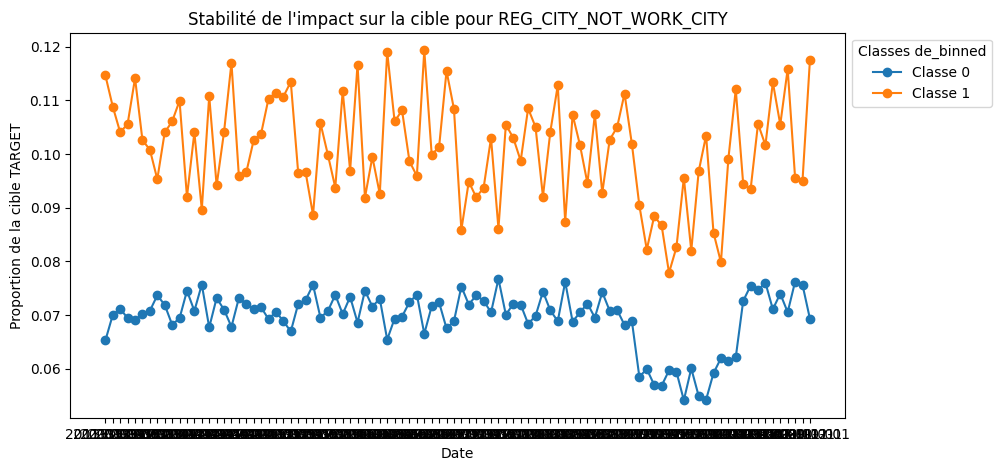

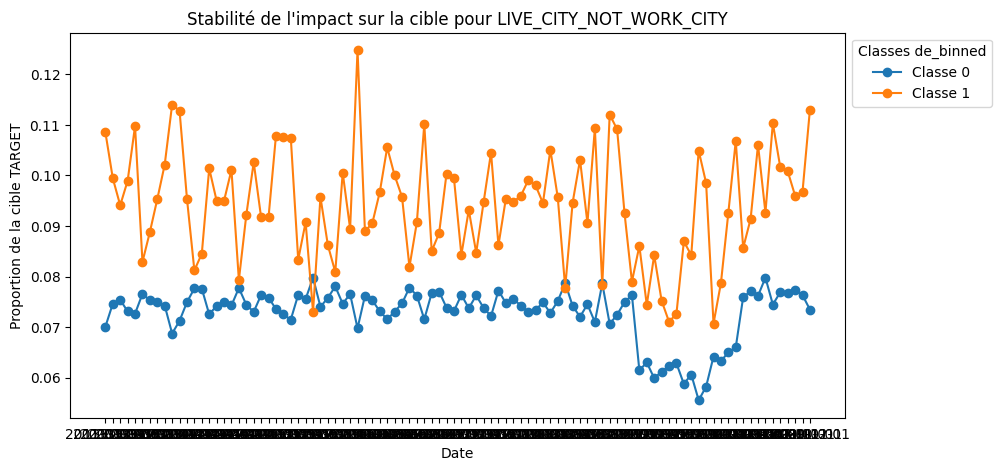

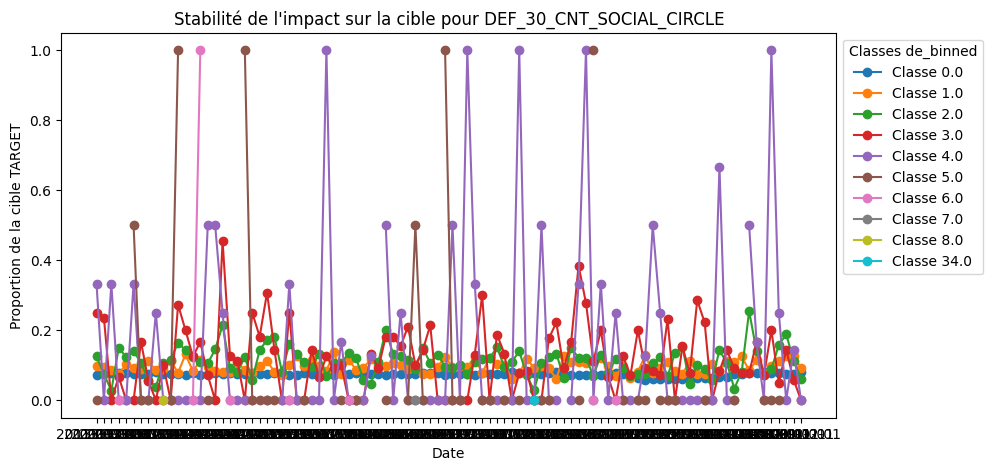

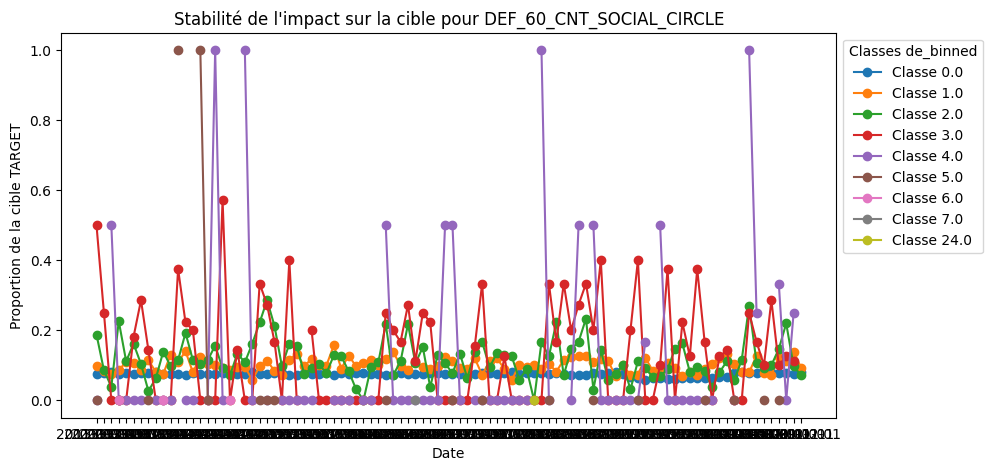

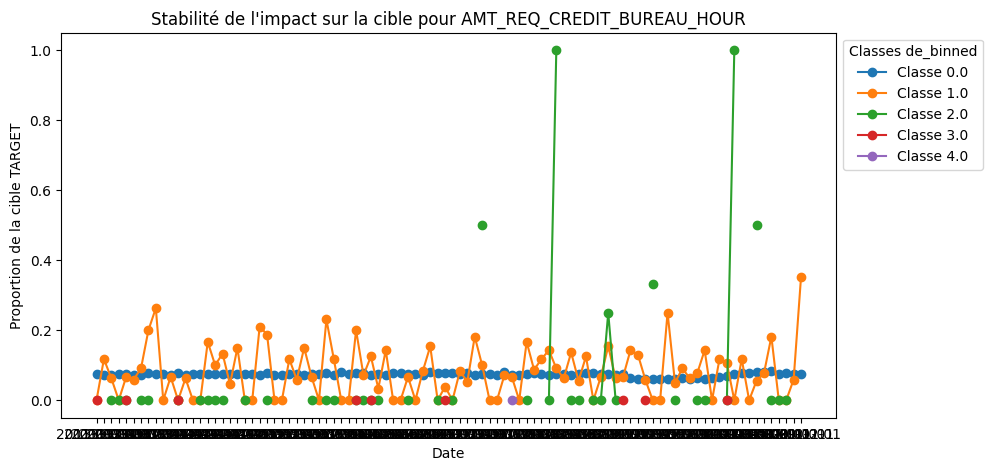

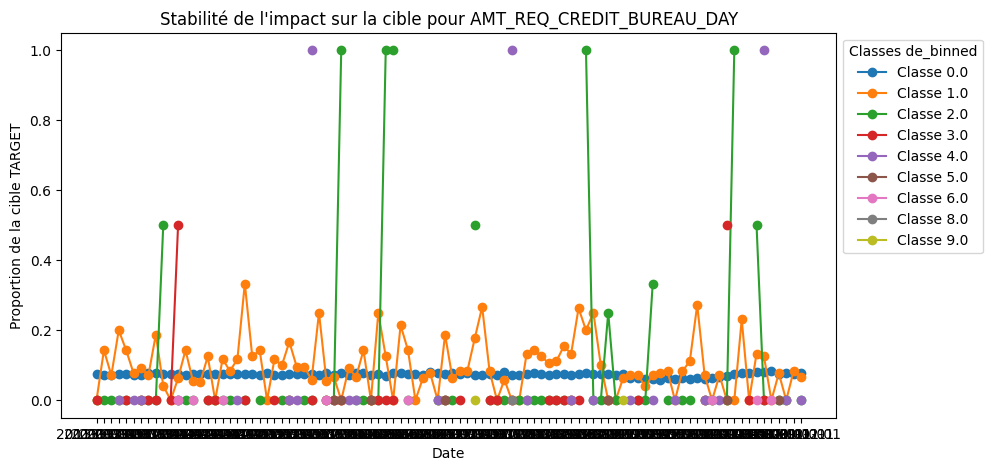

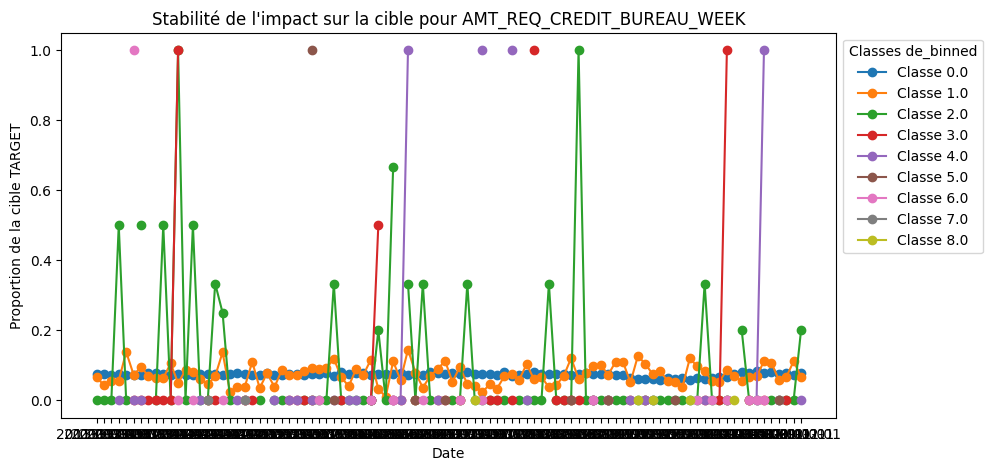

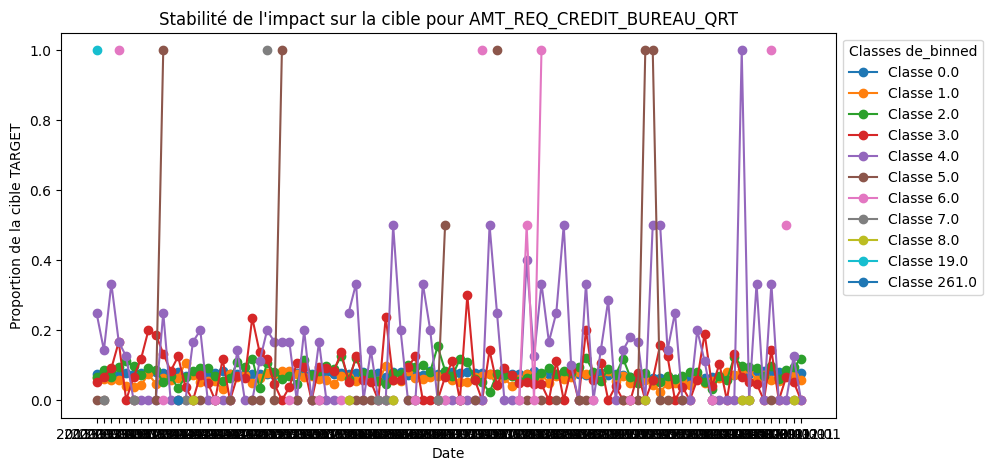

In [135]:
for var in var_to_categorize :
    plot_stability(var)

In [45]:
var_categ_good = ['FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT'
                  'REGION_RATING_CLIENT_W_CITY']

var_categ_tri = ["FLAG_WORK_PHONE", "FLAG_PHONE", "LIVE_CITY_NOT_WORK_CITY"]

var_categ_bad = [ "FLAG_MOBIL", "FLAG_CONT_MOBILE", "FLAG_EMAIL"
                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
                  'LIVE_REGION_NOT_WORK_REGION', 'FLAG_WORK_PHONE', "AMT_REG_CREDIT_BUREAU_QRT", 
                  "AMT_REG_CREDIT_BUREAU_WEEK", "AMT_REG_CREDIT_BUREAU_DAY", "AMT_REG_CREDIT_BUREAU_HOUR"]

var_categ_regroup = ["CNT_CHILDREN", "CNT_FAM_MEMBERS", "DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE"]

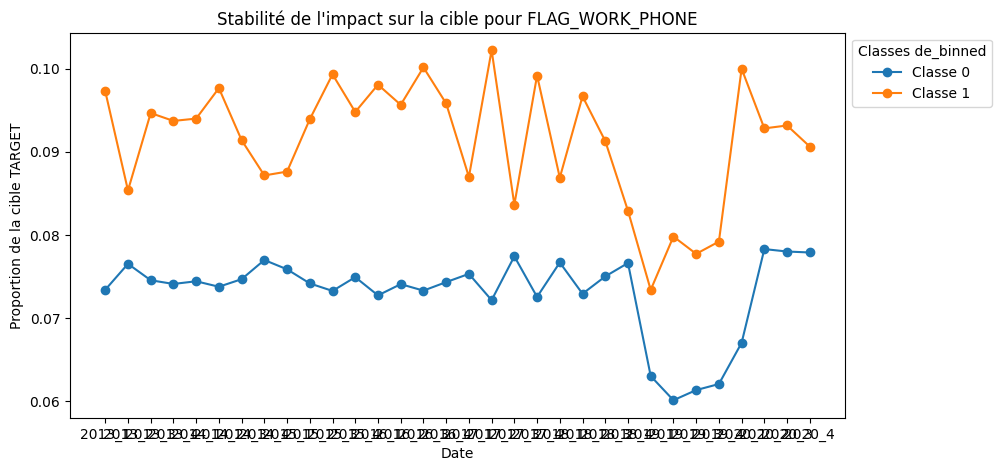

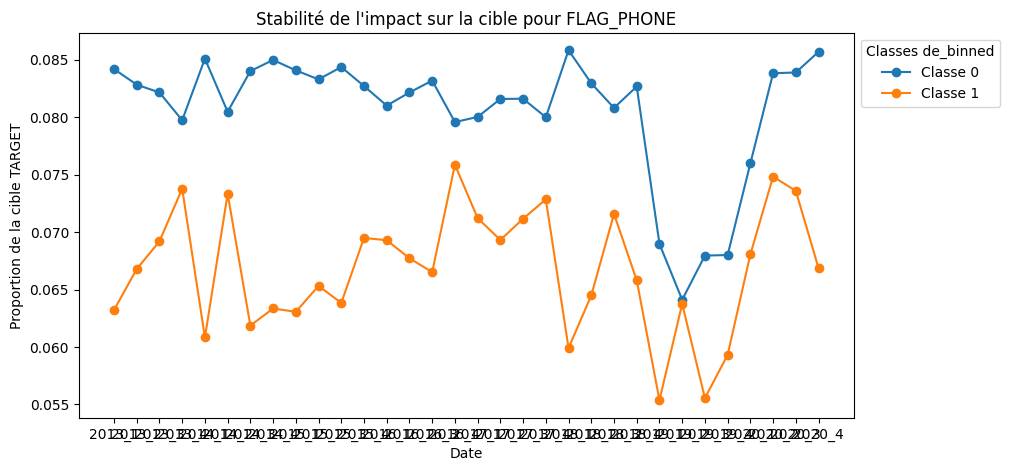

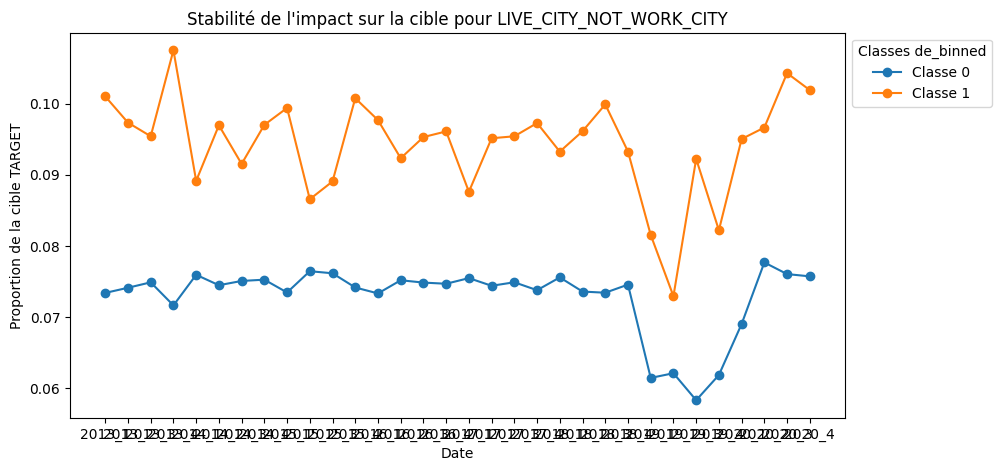

In [46]:
for var in var_categ_tri :
    plot_stability_tri(var)

# Conclusion

In [47]:
var_3_bins = ["DAYS_BIRTH", "EXT_SOURCE_2", 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY' ]

var_2_bins = ["AMT_GOODS_PRICE", "DAYS_REGISTRATION",  "DAYS_LAST_PHONE_CHANGE", "EXT_SOURCE_3",  
              "AMT_CREDIT", "AMT_ANNUITY",  "REGION_POPULATION_RELATIVE", "DAYS_EMPLOYED",
              "DAYS_REGISTRATION","DAYS_ID_PUBLISH", "AMT_REQ_CREDIT_BUREAU_YEAR", "AMT_REQ_CREDIT_BUREAU_MON", 
              'FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', "FLAG_WORK_PHONE", "FLAG_PHONE", "LIVE_CITY_NOT_WORK_CITY",]

var_a_jeter = ["AMT_INCOME_TOTAL", "HOURS_APPR_PROCESS_START", "FLAG_MOBIL", "FLAG_CONT_MOBILE", "FLAG_EMAIL"
                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
                  'LIVE_REGION_NOT_WORK_REGION', 'FLAG_WORK_PHONE', "AMT_REG_CREDIT_BUREAU_QRT", 
                  "AMT_REG_CREDIT_BUREAU_WEEK", "AMT_REG_CREDIT_BUREAU_DAY", "AMT_REG_CREDIT_BUREAU_HOUR"]

var_a_explorer = ["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "CNT_CHILDREN", "CNT_FAM_MEMBERS"
                  "DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE"]

# Création des intervalles

In [64]:
all_num_good = ["DAYS_BIRTH", "EXT_SOURCE_2", 
                "AMT_GOODS_PRICE", "DAYS_REGISTRATION",  "DAYS_LAST_PHONE_CHANGE", "EXT_SOURCE_3",  
              "AMT_CREDIT", "AMT_ANNUITY",  "REGION_POPULATION_RELATIVE", "DAYS_EMPLOYED",
              "DAYS_REGISTRATION","DAYS_ID_PUBLISH", "AMT_REQ_CREDIT_BUREAU_YEAR", "AMT_REQ_CREDIT_BUREAU_MON"]

all_categ_good = ['FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT',
                  'REGION_RATING_CLIENT_W_CITY', "FLAG_WORK_PHONE", "FLAG_PHONE", "LIVE_CITY_NOT_WORK_CITY"]

In [56]:
all_num_disc = [str(var+'_disc') for var in all_num_good]

In [57]:
for var in all_num_disc : 
    var_og = var.split('_disc')[0]
    intervalles = df.groupby(var)[var_og].agg(['min', 'max'])

    dict_renommage = {modalite: f'[{round(row["min"],2)}-{round(row["max"],2)}]' for modalite, row in intervalles.iterrows()}
    
    df[f'{var}_int'] = df[var].map(dict_renommage)

In [58]:
df[["AMT_GOODS_PRICE", "AMT_GOODS_PRICE_disc", 'AMT_GOODS_PRICE_disc_int']]

AMT_GOODS_PRICE  AMT_GOODS_PRICE_disc AMT_GOODS_PRICE_disc_int
0             1102500.0                     1     [679500.0-4050000.0]
1              270000.0                     0       [40500.0-676278.0]
2               67500.0                     0       [40500.0-676278.0]
3              900000.0                     1     [679500.0-4050000.0]
4              225000.0                     0       [40500.0-676278.0]
...                 ...                   ...                      ...
306102         598500.0                     0       [40500.0-676278.0]
306103         270000.0                     0       [40500.0-676278.0]
306104        1350000.0                     1     [679500.0-4050000.0]
306105         135000.0                     0       [40500.0-676278.0]
306106         450000.0                     0       [40500.0-676278.0]

[306107 rows x 3 columns]

In [59]:
final = [var for var in df.columns if '_disc_int' in var]

In [65]:
all = final.copy()
all.extend(all_categ_good)

In [66]:
final = df[all]

In [75]:
final.to_csv("../data/var_num.csv")